In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from glob import glob
import scipy
import pandas as pd
import pdb
from tqdm import tqdm
import pickle
import sys
from matplotlib import pyplot as plt
import h5py
from copy import deepcopy

In [4]:
from mlxtend.evaluate import bias_variance_decomp

In [5]:
sys.path.append('/home/akumar/nse/neural_control')

In [6]:
from loaders import load_sabes
from decoders import lr_decoder, lr_bias_variance
from segmentation import start_times, reach_segment_sabes
from utils import apply_df_filters

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Load up reaches and see if we can classify into normal vs. corrective. Here, we don't care about straightness vs. curvature, but rather 
# just filtering via velocity profile

In [7]:
data_files = glob('/mnt/Secondary/data/sabes/*.mat')

In [28]:
def reach_segment(data_file)    :
    dat = load_sabes(data_file)
    start_time = start_times[data_file.split('/')[-1].split('.mat')[0]]

    target_locs = []
    time_on_target = []
    valid_transition_times = []

    target_diff = np.diff(dat['target'].T)
    # This will yield the last index before the transition
    transition_times = np.sort(np.unique(target_diff.nonzero()[1]))
    #transition_times = target_diff.nonzero()[1]

    # For each transition, make a record of the location, time on target, and transition_vector
    # Throw away those targets that only appear for 1 timestep
    for i, transition_time in enumerate(transition_times):

        # Only lingers at the target for one timestep
        if i < len(transition_times) - 1:
            if np.diff(transition_times)[i] == 1:
                continue

        target_locs.append(dat['target'][transition_time][:])
        valid_transition_times.append(transition_time)
        
    for i, transition_time in enumerate(valid_transition_times):
            
        if i == 0:
            time_on_target.append(transition_time + 1)
        else:
            time_on_target.append(transition_time - valid_transition_times[i - 1] + 1)
            
    target_locs = np.array(target_locs)
    time_on_target = np.array(time_on_target)
    valid_transition_times = np.array(valid_transition_times)

    # Filter out by when motion starts
    if start_time > valid_transition_times[0]:
        init_target_loc = target_locs[valid_transition_times < start_time][-1]
    else:
        init_target_loc = target_locs[0]

    target_locs = target_locs[valid_transition_times > start_time]
    time_on_target = time_on_target[valid_transition_times > start_time]
    valid_transition_times = valid_transition_times[valid_transition_times > start_time]

    target_pairs = []
    for i in range(1, len(target_locs)):
        target_pairs.append((i - 1, i))

    # Velocity profiles
    vel = np.diff(dat['behavior'], axis=0)

    # Pair of target corrdinates
    valid_target_pairs = []
    # Tuple of indices that describes start and end of reach
    transition_times = []
    transition_vectors = []

    valid_target_pairs = [(target_locs[target_pairs[i][0]], target_locs[target_pairs[i][1]]) for i in range(len(target_pairs))]
    transition_times = [(valid_transition_times[target_pairs[i][0]] + 1, valid_transition_times[target_pairs[i][1]]) for i in range(len(target_pairs))]
    transition_vectors = [target_locs[target_pairs[i][1]] - target_locs[target_pairs[i][0]] for i in range(len(target_pairs))]


    velocity = scipy.ndimage.gaussian_filter1d(vel, axis=0, sigma=1)
    velocity_seg = [np.linalg.norm(velocity[t[0]:t[1], :], axis=1) for t in transition_times]
    velocity_normseg = [v/np.max(v) for v in velocity_seg]
    npks = [len(scipy.signal.find_peaks(v, height=0.15)[0]) for v in velocity_normseg]

    single_peak = np.argwhere(np.array(npks) == 1).squeeze()
    multi_peak = np.argwhere(np.bitwise_and(np.array(npks) > 1, np.array(npks) < 5)).squeeze()

    behavior = [dat['behavior'][t[0]:t[1]] for t in transition_times]
    centered_behavior = [b - b[0, :] for b in behavior]

    # Rotate by the transition vector
    theta = [np.arctan2((b[-1, :] - b[0, :])[1], (b[-1, :] - b[0, :])[0] ) for b in centered_behavior]

    R = lambda theta: np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    centrot_behavior = [b @ R(th) for (b, th) in zip(centered_behavior, theta)]

    return dat, transition_times, single_peak, multi_peak, velocity_seg, centrot_behavior, npks

In [41]:
def get_peak_assignments(multi_peak, velocity_seg):
    velmp = np.array(velocity_seg)[multi_peak]

    # Get the width of each peaks, exactly partitioning the time series

    peak_indices = [scipy.signal.find_peaks(v, height=0.15)[0] for v in velmp]
    peak_widths = [scipy.signal.peak_widths(v, peaks=pkidxs, rel_height=1.0) for v, pkidxs in zip(velmp, peak_indices)]

    # Assign points to the closest peak
    # Assign points to the closest peak
    def closest_peak(pks, pnt):
        pk_dist = [np.abs(pk - pnt) for pk in pks]
        if len(pk_dist) > 0:
            return np.argmin(pk_dist)
        else:
            # Shouldn't be used as these fall outside of both single peak and multi peak reaches
            return np.nan

    pkassign = [[closest_peak(peak_indices[j], t) for t in range(len(v))] for j, v in enumerate(velmp)]

    return np.array(pkassign)

/tmp/ipykernel_467/3658547629.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  velmp = np.array(velocity_seg)[multi_peak]
/tmp/ipykernel_467/3658547629.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pkassign)
/tmp/ipykernel_467/3515431907.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for v in np.array(

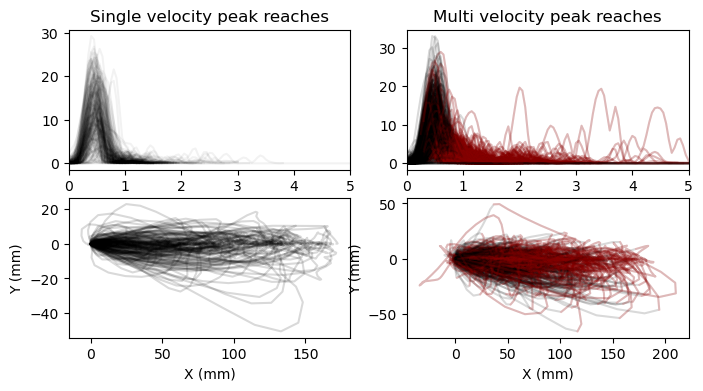

In [43]:
# Plot averaged velocity traces of single peak vs. multi peak velocities.
dat, transition_times, single_peak, multi_peak, velocity_seg, centrot_behavior, npks = reach_segment(data_files[1])
pkassign = get_peak_assignments(multi_peak, velocity_seg)

fig, ax  = plt.subplots(2, 2, figsize=(8, 4))

# Higlight the parts of trajectories implicated after the first peak as died out

for v in np.array(velocity_seg)[single_peak]:
    ax[0, 0].plot(50 * np.arange(len(v))/1000, v, alpha=0.05, color='k')
    ax[0, 0].set_xlim([0, 100*50/1000])

for i, v in enumerate(np.array(velocity_seg)[multi_peak]):
    ax[0, 1].plot(50 * np.arange(len(v))/1000, v, alpha=0.15, color='k')
    idxs = np.argwhere(np.array(pkassign[i]) > 0).squeeze()
    ax[0, 1].plot(50 * np.arange(len(v))[idxs]/1000, v[idxs], alpha=0.15, color='r')
    ax[0, 1].set_xlim([0, 100 * 50/1000])

# Plot the center aligned and rotated behavior below
for b in np.array(centrot_behavior)[single_peak]:
    ax[1, 0].plot(b[:, 0], b[:, 1], alpha=0.15, color='k')

for i, b in enumerate(np.array(centrot_behavior)[multi_peak]):
    ax[1, 1].plot(b[:, 0], b[:, 1], alpha=0.15, color='k')
    idxs = np.argwhere(np.array(pkassign[i]) > 0).squeeze()
    ax[1, 1].plot(b[idxs, 0], b[idxs, 1], alpha=0.15, color='r')

ax[0, 0].set_title('Single velocity peak reaches', fontsize=12)
ax[0, 1].set_title('Multi velocity peak reaches', fontsize=12)
ax[0, 0].set_xlabel('Time (ms)')
ax[0, 1].set_xlabel('Time (ms)')

ax[1, 0].set_xlabel('X (mm)')
ax[1, 0].set_ylabel('Y (mm)')

ax[1, 1].set_xlabel('X (mm)')
ax[1, 1].set_ylabel('Y (mm)')

fig.savefig('/home/akumar/nse/neural_control/figs/decodingbias/reach_examples.pdf', bbox_inches='tight', pad_inches=0)

(array([244., 118.,   0.,  26.,   0.,   2.,   2.,   0.,   1.,   1.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

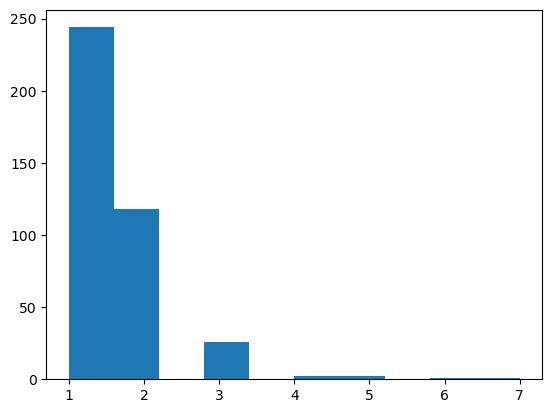

In [62]:
plt.hist(npks)

In [ ]:
# Seems to work fairly well. Now, given this separation, train decoders using FCCA/PCA across dimensionalities and datafiles. Use the no CV fits

In [8]:
# Load indy, sabes dataframes
with open('/mnt/Secondary/data/postprocessed/indy_dimreduc_nocv.dat', 'rb') as f:
    indy_df = pickle.load(f)

for f in indy_df:
    f['data_file'] = f['data_file'].split('/')[-1]

indy_df = pd.DataFrame(indy_df)
with open('/mnt/Secondary/data/postprocessed/loco_dimreduc_nocv_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)

In [11]:
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)
loco_df = apply_df_filters(loco_df, loader_args={'bin_width': 50,
                                    'filter_fn': 'none',
                                    'filter_kwargs': {},
                                    'boxcox': 0.5,
                                    'spike_threshold': 100,
                                    'region': 'M1'})

In [9]:
sabes_df = pd.concat([indy_df, loco_df])

In [32]:
dimvals = np.array([2, 6, 10, 15, 20, 30])
decoding_win = 5
lags = np.array([2, 4])

dpath = '/mnt/Secondary/data/sabes'
data_files = np.unique(sabes_df['data_file'].values)


mse = np.zeros((len(data_files), len(lags), dimvals.size, 2, 6))
bias = np.zeros(mse.shape)
var = np.zeros(mse.shape)

for i, data_file in tqdm(enumerate(data_files)):
    dat, transition_times, single_peak, multi_peak, velocity_seg, centrot_behavior = reach_segment('%s/%s' % (dpath, data_file))
    for j, lag in enumerate(lags):
        for k, dim in enumerate(dimvals):
            pcadf = apply_df_filters(sabes_df, data_file=data_file, dimreduc_method='PCA', dim=dim)
            lqgdf = apply_df_filters(sabes_df, data_file=data_file, dimreduc_method='LQGCA', dim=dim)

            try:
                assert(pcadf.shape[0] == 1)
                assert(lqgdf.shape[0] == 1)
            except:
                pdb.set_trace()
            Vpca = pcadf.iloc[0]['coef']
            Vlqg = lqgdf.iloc[0]['coef']
            Z = dat['behavior'].squeeze()
            X = dat['spike_rates'].squeeze()
    
            # Apply lag
            X = X[lag:, :]
            Z = Z[:-lag, :]

            # Exclude any reaches that lie within +/- lag of the start/end of the session
            too_soon = [j for j in range(len(transition_times)) if transition_times[j][0] < lag]
            too_late = [j for j in range(len(transition_times)) if transition_times[j][1] > dat['behavior'].shape[0] - lag]

            single_peak_cp = list(deepcopy(single_peak))
            multi_peak_cp = list(deepcopy(multi_peak))

            for idx in too_soon:
                if idx in single_peak_cp:
                    single_peak_cp.remove(idx)
                elif idx in multi_peak_cp:
                    multi_peak_cp.remove(idx)
            for idx in too_late:
                if idx in single_peak_cp:
                    single_peak_cp.remove(idx)
                elif idx in multi_peak_cp:
                    multi_peak_cp.remove(idx)

            # Trialize
            Xsp = [X[transition_times[j][0]:transition_times[j][1]] for j in single_peak_cp]
            Zsp = [Z[transition_times[j][0]:transition_times[j][1]] for j in single_peak_cp]
            Xmp = [X[transition_times[j][0]:transition_times[j][1]] for j in multi_peak_cp]
            Zmp = [Z[transition_times[j][0]:transition_times[j][1]] for j in multi_peak_cp]

            Xpca_sp = [x @ Vpca for x in Xsp]
            Xpca_mp = [x @ Vpca for x in Xmp]

            Xlqg_sp = [x @ Vlqg for x in Xsp]
            Xlqg_mp = [x @ Vlqg for x in Xmp]

            # Feed into lr_decoder. Use lag of 0 since we already applied, but feed in the decoding window
            mse_, bias_, var_ = lr_bias_variance(Xpca_mp, Xpca_sp, Zmp, Zsp, 0, 0, decoding_window=decoding_win, n_boots=500) 
            
            mse[i, j, k, 0] = mse_
            bias[i, j, k, 0] = bias_
            var[i, j, k, 0] = var_                        
                        
            # Feed into lr_decoder. Use lag of 0 since we already applied, but feed in the decoding window
            mse_, bias_, var_ = lr_bias_variance(Xlqg_mp, Xlqg_sp, Zmp, Zsp, 0, 0, decoding_window=decoding_win, n_boots=500) 
            
            mse[i, j, k, 1] = mse_
            bias[i, j, k, 1] = bias_
            var[i, j, k, 1] = var_                        

0it [00:00, ?it/s]/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of list

In [22]:
with open('biasvartmp.dat', 'wb') as f:
    f.write(pickle.dumps(mse))
    f.write(pickle.dumps(bias))
    f.write(pickle.dumps(var))

In [27]:
# let's do a preliminary analysis on just the sabes data so we can move forward 

(array([6., 2., 0., 1., 5., 5., 5., 4., 4., 3.]),
 array([0.02864372, 0.03856912, 0.04849452, 0.05841992, 0.06834532,
        0.07827072, 0.08819612, 0.09812152, 0.10804692, 0.11797232,
        0.12789772]),
 <BarContainer object of 10 artists>)

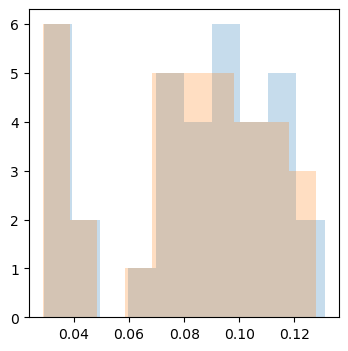

In [28]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(np.linalg.norm(bias[:, 1, -1, 0, 2:4], axis=-1), alpha=0.25)
ax.hist(np.linalg.norm(bias[:, 1, -1, 1, 2:4], axis=-1), alpha=0.25)

(array([4., 6., 1., 6., 9., 5., 1., 1., 1., 1.]),
 array([0.00055077, 0.00142489, 0.00229901, 0.00317313, 0.00404724,
        0.00492136, 0.00579548, 0.00666959, 0.00754371, 0.00841783,
        0.00929195]),
 <BarContainer object of 10 artists>)

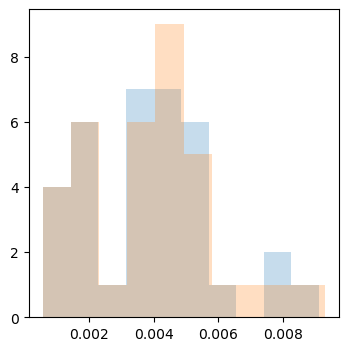

In [30]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(np.linalg.norm(var[:, 1, -1, 0, 2:4], axis=-1), alpha=0.25)
ax.hist(np.linalg.norm(var[:, 1, -1, 1, 2:4], axis=-1), alpha=0.25)

(array([4., 4., 0., 2., 3., 6., 4., 5., 4., 3.]),
 array([0.02940845, 0.03977582, 0.05014319, 0.06051055, 0.07087792,
        0.08124529, 0.09161265, 0.10198002, 0.11234739, 0.12271475,
        0.13308212]),
 <BarContainer object of 10 artists>)

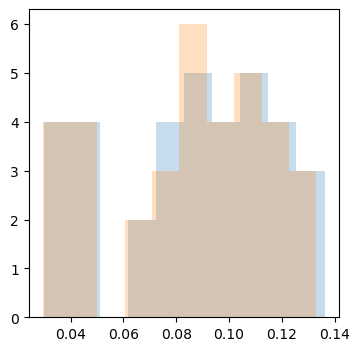

In [31]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(np.linalg.norm(mse[:, 1, -1, 0, 2:4], axis=-1), alpha=0.25)
ax.hist(np.linalg.norm(mse[:, 1, -1, 1, 2:4], axis=-1), alpha=0.25)

In [ ]:
# This is odd, we should keep track of r^2 as well. Perhaps the overall decoding on the multipeak reaches is just not high enough.

In [ ]:
# Across data files, what is the histogram of the bias/variance across the 

### Windowed Bias vs. Variance

In [45]:
data_files = glob('/mnt/Secondary/data/sabes/*.mat')
dat = load_sabes(data_files[1])
dat = reach_segment_sabes(dat, start_times[data_files[1].split('/')[-1].split('.mat')[0]])

Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [49]:
# with open('/mnt/Secondary/data/postprocessed/indy_dimreduc_nocv.dat', 'rb') as f:
#     rl = pickle.load(f)
# sabes_df = pd.DataFrame(rl)

# data_idx = 0
# data_file = np.unique(sabes_df['data_file'].values)[data_idx]

# dat = load_sabes(data_file)
# dat = reach_segment_sabes(dat, start_times[data_file.split('/')[-1].split('.mat')[0]])

fls = glob('/home/akumar/nse/neural_control/data/biasvariance_vst/*.dat')
rl = []
for fl in fls:
    didx = int(fl.split('didx')[1].split('_')[0])
    with open(fl, 'rb') as f:
        bias = pickle.load(f)
        var = pickle.load(f)
        mse = pickle.load(f)
        wr2 = pickle.load(f)
        windows = pickle.load(f)        

    result = {}
    result['didx'] = didx
    result['bias'] = bias
    result['var'] = var
    result['mse'] = mse
    result['r2'] = wr2
    result['window'] = np.squeeze(windows)

    rl.append(result)

dvt_df = pd.DataFrame(rl)

In [50]:
# Create a new dataframe where we flatten across ranks
didxs = np.unique(dvt_df['didx'].values)
rl = []
for didx in didxs:
    d = apply_df_filters(dvt_df, didx=didx)
    result = {}

    windows = []
    bias = []
    var = []
    mse = []
    r2 = []
    for j in range(d.shape[0]):
        windows.extend(d.iloc[j]['window'])
        bias.append(d.iloc[j]['bias'])
        var.append(d.iloc[j]['var'])
        mse.append(d.iloc[j]['mse'])
        r2.append(d.iloc[j]['r2'])
    
    window_centers = [np.mean(w) for w in windows]
    center_order = np.argsort(window_centers)
    windows = np.array(windows)[center_order]
    bias = np.concatenate(bias)[center_order]
    var = np.concatenate(var)[center_order]
    mse = np.concatenate(mse)[center_order]
    r2 = np.concatenate(r2)[center_order]

    result['windows'] = windows
    result['didx'] = didx
    result['bias'] = bias
    result['var'] = var
    result['mse'] = mse
    result['r2'] = r2

    rl.append(result)

dvt_df = pd.DataFrame(rl)

/tmp/ipykernel_26035/2380266624.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  r2f = np.array(r2f).T
/tmp/ipykernel_26035/2380266624.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  r2p = np.array(r2p).T


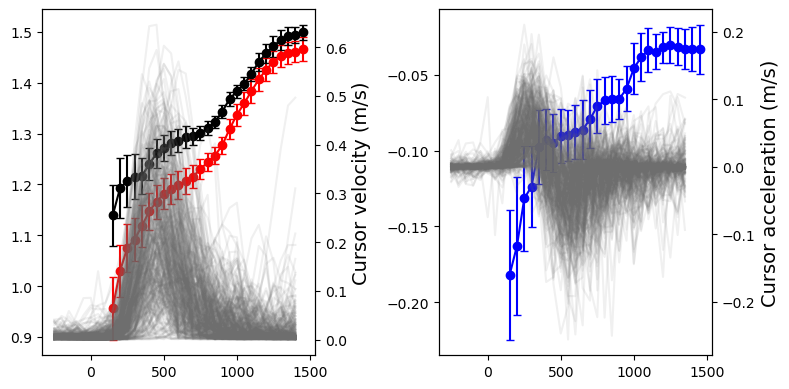

In [57]:
#fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
a = ax[0].twinx()
a2 = ax[1].twinx()


df_ = dvt_df
windows = dvt_df.iloc[0]['windows']
window_centers = np.mean(windows, axis=1)

r2f = []
r2p = []

mse_f = []
mse_p = []

bias_f = []
bias_p = []

var_f = []
var_p = []

for j in range(df_.shape[0]):
    r2f.append(df_.iloc[j]['r2'][:, 1, 4])
    r2p.append(df_.iloc[j]['r2'][:, 0, 4])        

    mse_f.append(np.linalg.norm(df_.iloc[j]['mse'][:, 1, 2:4], axis=-1))
    mse_p.append(np.linalg.norm(df_.iloc[j]['mse'][:, 0, 2:4], axis=-1))        

    bias_f.append(np.linalg.norm(df_.iloc[j]['bias'][:, 3, 2:4], axis=-1))
    bias_p.append(np.linalg.norm(df_.iloc[j]['bias'][:, 2, 2:4], axis=-1))        

    var_f.append(np.linalg.norm(df_.iloc[j]['var'][:, 1, 2:4], axis=-1))
    var_p.append(np.linalg.norm(df_.iloc[j]['var'][:, 0, 2:4], axis=-1))        

r2f = np.array(r2f).T
r2p = np.array(r2p).T

completed = [idx for idx, x in enumerate(r2f) if x.size == 30]

r2f = []
r2p = []

mse_f = []
mse_p = []

bias_f = []
bias_p = []

var_f = []
var_p = []

for j in completed:
    r2f.append(df_.iloc[j]['r2'][:, 1, 4])
    r2p.append(df_.iloc[j]['r2'][:, 0, 4])        

    mse_f.append(np.linalg.norm(df_.iloc[j]['mse'][:, 1, 2:4], axis=-1))
    mse_p.append(np.linalg.norm(df_.iloc[j]['mse'][:, 0, 2:4], axis=-1))        

    bias_f.append(np.linalg.norm(df_.iloc[j]['bias'][:, 1, 2:4], axis=-1))
    bias_p.append(np.linalg.norm(df_.iloc[j]['bias'][:, 0, 2:4], axis=-1))        

    var_f.append(np.linalg.norm(df_.iloc[j]['var'][:, 1, 2:4], axis=-1))
    var_p.append(np.linalg.norm(df_.iloc[j]['var'][:, 0, 2:4], axis=-1))        

r2f = np.array(bias_f).T
r2p = np.array(bias_p).T

transition_times = np.array(dat['transition_times'])
vel_all = []
acc_all = []
for tt in transition_times[::2]:
    vel = np.linalg.norm(np.diff(dat['behavior'][tt[0] - 5:tt[0] + 30], axis=0), axis=1)/(1e3 * 0.05)
    acc = np.diff(vel)
    vel_all.append(vel)
    acc_all.append(acc)
    a.plot(50 * np.arange(-5, 29), vel, color='#6e6e6e', alpha=0.1)
    a.set_ylabel('Cursor velocity (m/s)', fontsize=14)
    a2.plot(50 * np.arange(-5, 28), acc, color='#6e6e6e', alpha=0.1)
    a2.set_ylabel('Cursor acceleration (m/s)', fontsize=14)

ax[0].errorbar(50 * window_centers, [np.mean(r) for r in r2f], [np.std(r)/np.sqrt(r.size) for r in r2f], linestyle='', capsize=3, color='r', zorder=0)
ax[0].errorbar(50 * window_centers, [np.mean(r) for r in r2p], [np.std(r)/np.sqrt(r.size) for r in r2p], linestyle='', capsize=3, color='k', zorder=0)

ax[0].plot(50 * window_centers, [np.mean(r) for r in r2f], '-o', color='r', zorder=0, label='FCCA')
ax[0].plot(50 * window_centers, [np.mean(r) for r in r2p], '-o', color='k', zorder=0, label='PCA')

ax[1].errorbar(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], 
                   [np.std(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(r2f, r2p)], linestyle='', capsize=3, color='b')
ax[1].plot(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], '-o', color='b')


fig.tight_layout()
#ax[0].set_ylim([0, 0.5])
#ax[1].set_ylim([0, 0.15])
# a2.set_ylim([-0.25, 0.25])


# ax[0].set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
# ax[1].set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)
# ax[0].set_xlabel('Decoding Window Center (ms)', fontsize=14)
# ax[1].set_xlabel('Decoding Window Center (ms)', fontsize=14)


# ax[0].set_title('Projection Dimension 6', fontsize=14)
# ax[1].set_title('Projection Dimension 6', fontsize=14)

# ax[0].legend(loc='upper left')
# ax[1].legend(loc='upper right')

# # In the last figure, plot the reaches
# z = []

# # reaches1 = np.array(dat['transition_times'])[np.argwhere(dat['target_pair_error'] >= high_error)[:, 0]]
# # reaches2 = np.array(dat['transition_times'])[np.argwhere(dat['target_pair_error'] <= low_error)[:, 0]]
# for i in range(transition_times.shape[0]):
#     z.append(dat['behavior'][transition_times[i, 0]:transition_times[i, 1]])
    
# # for i in range(0, transition_times.shape[0], 3):
# #     z_ = z[i] - z[i][0]
# #     ax[2].plot(z_[:, 0], z_[:, 1], color='k', alpha=0.25)
# #     ax[2].set_xlim([-180, 180])
# #     ax[2].set_ylim([-100, 100])    
# #     ax[2].set_aspect('equal')
# #     ax[2].set_xlabel('X (mm)', fontsize=12)
# #     ax[2].set_ylabel('Y (mm)', fontsize=12)
# #     ax[2].set_title('Example Reaches', fontsize=14)

# fig.tight_layout()
# # fig.savefig('/home/akumar/nse/neural_control/figs/decodingvtsummary/final.pdf', bbox_inches='tight', pad_inches=0)

transition_times = np.array(dat['transition_times'])
vel_all = []
acc_all = []
for tt in transition_times[::2]:
    vel = np.linalg.norm(np.diff(dat['behavior'][tt[0] - 5:tt[0] + 30], axis=0), axis=1)/(1e3 * 0.05)
    acc = np.diff(vel)
    vel_all.append(vel)
    acc_all.append(acc)
    a.plot(50 * np.arange(-5, 29), vel, color='#6e6e6e', alpha=0.1)
    a.set_ylabel('Cursor velocity (m/s)', fontsize=14)
    a2.plot(50 * np.arange(-5, 28), acc, color='#6e6e6e', alpha=0.1)
50 * window_centers

In [31]:
window_centers

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29.])

### Dim 6, Narrower Windows, attempting to debug the weird time dynamics

In [11]:
# with open('/mnt/Secondary/data/postprocessed/indy_dimreduc_nocv.dat', 'rb') as f:
#     rl = pickle.load(f)
# sabes_df = pd.DataFrame(rl)

# data_idx = 0
# data_file = np.unique(sabes_df['data_file'].values)[data_idx]

# dat = load_sabes(data_file)
# dat = reach_segment_sabes(dat, start_times[data_file.split('/')[-1].split('.mat')[0]])

fls = glob('/home/akumar/nse/neural_control/data/biasvariance_vst2/*.dat')
rl = []
for fl in fls:
    didx = int(fl.split('didx')[1].split('_')[0])
    with open(fl, 'rb') as f:
        bias = pickle.load(f)
        var = pickle.load(f)
        mse = pickle.load(f)
        wr2 = pickle.load(f)
        windows = pickle.load(f)        

    result = {}
    result['didx'] = didx
    result['bias'] = bias
    result['var'] = var
    result['mse'] = mse
    result['r2'] = wr2
    result['window'] = np.squeeze(windows)

    rl.append(result)

dvt_df = pd.DataFrame(rl)

In [12]:
# Create a new dataframe where we flatten across ranks
didxs = np.unique(dvt_df['didx'].values)
rl = []
for didx in didxs:
    d = apply_df_filters(dvt_df, didx=didx)
    result = {}

    windows = []
    bias = []
    var = []
    mse = []
    r2 = []
    for j in range(d.shape[0]):
        windows.extend(d.iloc[j]['window'])
        bias.append(d.iloc[j]['bias'])
        var.append(d.iloc[j]['var'])
        mse.append(d.iloc[j]['mse'])
        r2.append(d.iloc[j]['r2'])
    
    window_centers = [np.mean(w) for w in windows]
    center_order = np.argsort(window_centers)
    windows = np.array(windows)[center_order]
    bias = np.concatenate(bias)[center_order]
    var = np.concatenate(var)[center_order]
    mse = np.concatenate(mse)[center_order]
    r2 = np.concatenate(r2)[center_order]

    result['windows'] = windows
    result['didx'] = didx
    result['bias'] = bias
    result['var'] = var
    result['mse'] = mse
    result['r2'] = r2

    rl.append(result)

dvt_df = pd.DataFrame(rl)

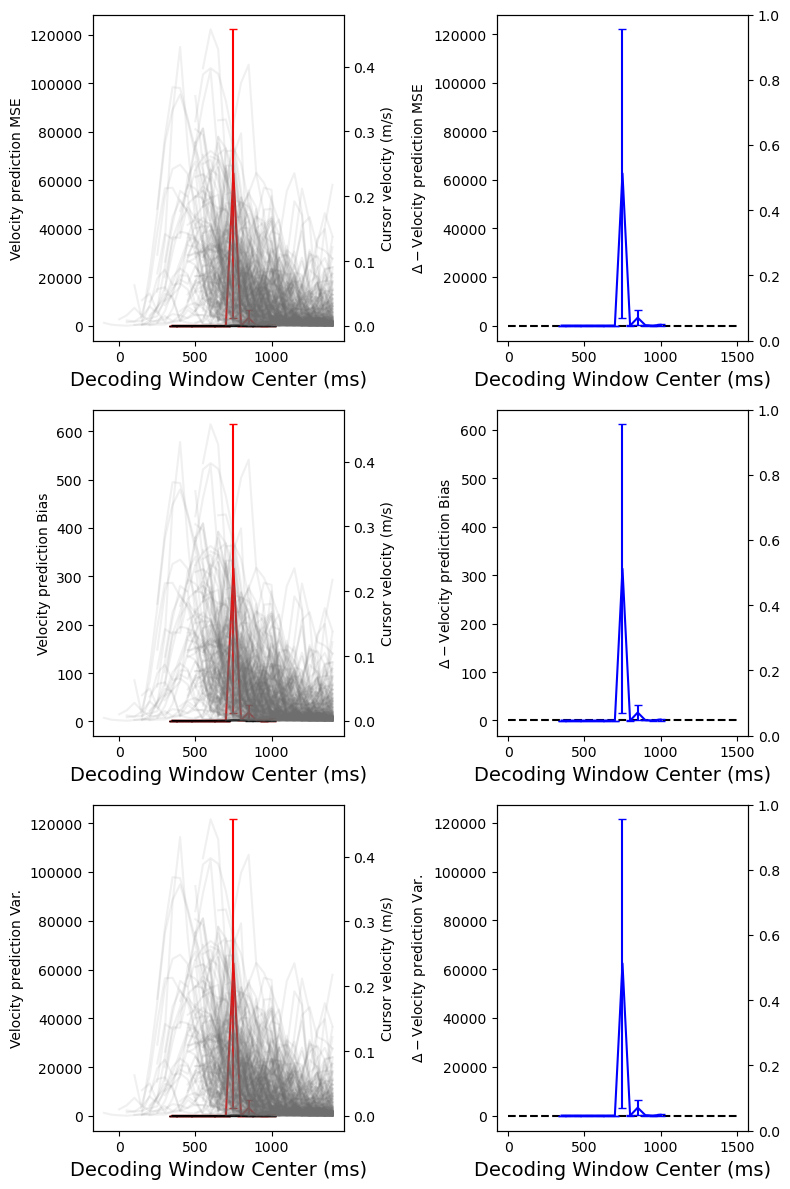

In [66]:
#fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplots(3, 2, figsize=(8, 12))

a = [ax[j, 0].twinx() for j in range(3)]
a2 = [ax[j, 1].twinx() for j in range(3)]

df_ = dvt_df
windows = dvt_df.iloc[0]['windows']
window_centers = np.mean(windows, axis=1)

r2f = []
r2p = []

mse_f = []
mse_p = []

bias_f = []
bias_p = []

var_f = []
var_p = []

for j in range(df_.shape[0]):
    r2f.append(df_.iloc[j]['r2'][:, 5, 4])
    r2p.append(df_.iloc[j]['r2'][:, 4, 4])        

    mse_f.append(np.linalg.norm(df_.iloc[j]['mse'][:, 5, 2:4], axis=-1))
    mse_p.append(np.linalg.norm(df_.iloc[j]['mse'][:, 4, 2:4], axis=-1))        

    bias_f.append(np.linalg.norm(df_.iloc[j]['bias'][:, 5, 2:4], axis=-1))
    bias_p.append(np.linalg.norm(df_.iloc[j]['bias'][:, 4, 2:4], axis=-1))        

    var_f.append(np.linalg.norm(df_.iloc[j]['var'][:, 5, 2:4], axis=-1))
    var_p.append(np.linalg.norm(df_.iloc[j]['var'][:, 4, 2:4], axis=-1))        

r2f = np.array(r2f)
r2p = np.array(r2p)

completed = [idx for idx, x in enumerate(r2f) if x.size == 30]

r2f = []
r2p = []

mse_f = []
mse_p = []

bias_f = []
bias_p = []

var_f = []
var_p = []

for j in completed:
    r2f.append(df_.iloc[j]['r2'][:, 7, 4])
    r2p.append(df_.iloc[j]['r2'][:, 6, 4])        

    mse_f.append(np.linalg.norm(df_.iloc[j]['mse'][:, 5, 2:4], axis=-1))
    mse_p.append(np.linalg.norm(df_.iloc[j]['mse'][:, 4, 2:4], axis=-1))        

    bias_f.append(np.linalg.norm(df_.iloc[j]['bias'][:, 5, 2:4], axis=-1))
    bias_p.append(np.linalg.norm(df_.iloc[j]['bias'][:, 4, 2:4], axis=-1))        

    var_f.append(np.linalg.norm(df_.iloc[j]['var'][:, 5, 2:4], axis=-1))
    var_p.append(np.linalg.norm(df_.iloc[j]['var'][:, 4, 2:4], axis=-1))        

mse_f = np.array(mse_f).T
mse_p = np.array(mse_p).T

bias_f = np.array(bias_f).T
bias_p = np.array(bias_p).T

var_f = np.array(var_f).T
var_p = np.array(var_p).T

transition_times = np.array(dat['transition_times'])
vel_all = []
acc_all = []

for tt in transition_times[::2]:
    vel = np.linalg.norm(np.diff(dat['behavior'][tt[0] - 5:tt[0] + 30], axis=0), axis=1)/(1e3 * 0.05)
    velocity_normseg = vel/np.max(vel)
    pks = scipy.signal.find_peaks(velocity_normseg, height=0.15)[0]

    # Plot only the secondary velocity peaks, which are what the r^2 are assessed against
    def closest_peak(pks, pnt):
        pk_dist = [np.abs(pk - pnt) for pk in pks]
        return np.argmin(pk_dist)

    pkassign = np.array([closest_peak(pks, t) for t in range(len(vel))])
    t = np.arange(-5, 29)[pkassign > 0]
    vel = vel[pkassign > 0]
    acc = np.diff(vel)
    # vel_all.append(vel)
    # acc_all.append(acc)
    for a_ in a:
        a_.plot(50 * t, vel, color='#6e6e6e', alpha=0.1)
        a_.set_ylabel('Cursor velocity (m/s)')
    #for a2_ in a2:
        #a2_.plot(50 * t[:-1], acc, color='#6e6e6e', alpha=0.1)
        #a2_.set_ylabel('Cursor acceleration (m/s)', fontsize=14)

ax[0, 0].errorbar(50 * window_centers, [np.mean(r) for r in mse_f], [np.std(r)/np.sqrt(r.size) for r in mse_f], linestyle='-', capsize=3, color='r', zorder=0)
ax[0, 0].errorbar(50 * window_centers, [np.mean(r) for r in mse_p], [np.std(r)/np.sqrt(r.size) for r in mse_p], linestyle='-', capsize=3, color='k', zorder=0)
ax[0, 1].errorbar(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(mse_f, mse_p)], 
                [np.std(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(mse_f, mse_p)], linestyle='-', capsize=3, color='b')

# ax[0].plot(50 * window_centers, [np.mean(r) for r in mse_f], [np.std(r)/np.sqrt(r.size) for r in mse_f], e='', capsize=3, color='r', zorder=0)
# ax[0].plot(50 * window_centers, [np.mean(r) for r in mse_p], [np.std(r)/np.sqrt(r.size) for r in mse_p], linestyle='', capsize=3, color='k', zorder=0)


# ax[0].plot(50 * window_centers, [np.mean(r) for r in r2f], '-o', color='r', zorder=0, label='FCCA')
# ax[0].plot(50 * window_centers, [np.mean(r) for r in r2p], '-o', color='k', zorder=0, label='PCA')

ax[1, 0].errorbar(50 * window_centers, [np.mean(r) for r in bias_f], [np.std(r)/np.sqrt(r.size) for r in bias_f], linestyle='-', capsize=3, color='r', zorder=0)
ax[1, 0].errorbar(50 * window_centers, [np.mean(r) for r in bias_p], [np.std(r)/np.sqrt(r.size) for r in bias_p], linestyle='-', capsize=3, color='k', zorder=0)
ax[1, 1].errorbar(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(bias_f, bias_p)], 
                [np.std(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(bias_f, bias_p)], linestyle='-', capsize=3, color='b')


ax[2, 0].errorbar(50 * window_centers, [np.mean(r) for r in var_f], [np.std(r)/np.sqrt(r.size) for r in var_f], linestyle='-', capsize=3, color='r', zorder=0)
ax[2, 0].errorbar(50 * window_centers, [np.mean(r) for r in var_p], [np.std(r)/np.sqrt(r.size) for r in var_p], linestyle='-', capsize=3, color='k', zorder=0)
ax[2, 1].errorbar(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(var_f, var_p)], 
                [np.std(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(var_f, var_p)], linestyle='-', capsize=3, color='b')

for j in range(3):
    ax[j, 1].hlines(0, 0, 1500, linestyles='dashed', colors='k')

ax[0, 0].set_ylabel('Velocity prediction MSE')
ax[1, 0].set_ylabel('Velocity prediction Bias')
ax[2, 0].set_ylabel('Velocity prediction Var.')

ax[0, 1].set_ylabel(r'$\Delta-$' + 'Velocity prediction MSE')
ax[1, 1].set_ylabel(r'$\Delta-$' + 'Velocity prediction Bias')
ax[2, 1].set_ylabel(r'$\Delta-$' + 'Velocity prediction Var.')

# ax[0].set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
# ax[1].set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)

for j in range(3):
    ax[j, 0].set_xlabel('Decoding Window Center (ms)', fontsize=14)
    ax[j, 1].set_xlabel('Decoding Window Center (ms)', fontsize=14)

fig.tight_layout()
#fig.savefig('/home/akumar/nse/neural_control/figs/decodingbias/singlepktrain_multipeaktest.pdf', bbox_inches='tight', pad_inches=0)